In [56]:
import h5py
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from scipy import stats

from nilearn import datasets, plotting
# Note nilearn plotting incompatible with Mtplotlib version >= 3.1

from pathlib import Path
import os
import re
import pandas as pd

from tqdm import tqdm

In [3]:
h5_key = 'latent'
## Define paths
basedir = Path('..')
datadir = basedir / 'data'
rawdir = datadir / 'raw'
gccadir = datadir / 'interim' / 'gcca'
externaldir = datadir / 'external'

## Load Files

In [4]:
def get_files(path,
              level='(e|n)',
              subject='([0-9]{3})',
              task='(.+?)',
              filetype='h5',
              flag=''):
    files = []
    query = f'^{level}_sub-'
    query += f'{subject}_ses-1_'
    query += f'task-{task}{flag}\.{filetype}'
    for f in os.listdir(path):
        match = re.search(query, f)
        if match:
            files.append((f, match.groups()))
    
    return(files)

In [5]:
len(get_files(path=gccadir))

228

In [6]:
# plot on fsa5 surface:
fsa5 = datasets.fetch_surf_fsaverage()

In [7]:
def visualize_embeddings(embeddings, level, task, statistic, save=True, vmax=None, symmetric_cbar=True,colorbar=False, n_embed = 3):
    plt.clf()
    res_scale = 2
    fig, axes = plt.subplots(n_embed, 4, subplot_kw={'projection': '3d'}, figsize=(res_scale*4, res_scale*n_embed))
    
    plt.subplots_adjust(wspace=0, hspace=0)


    for i in range(n_embed):
        ax = axes[i]
        X = embeddings[:, i]

        cortex_left = nib.freesurfer.read_label(externaldir / 'lh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_left] = X[:len(cortex_left)]

        plotting.plot_surf_stat_map(fsa5.infl_left, 
          conn_map, hemi='left', colorbar=False, cmap='RdBu', axes = ax[0],
          vmax=vmax, symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_left,
          conn_map, hemi='left', colorbar=False, cmap='RdBu', view='medial', axes=ax[1], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

        cortex_right = nib.freesurfer.read_label(externaldir / 'rh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_right] = X[len(cortex_left):]

        plotting.plot_surf_stat_map(fsa5.infl_right, 
          conn_map, hemi='right', colorbar=False, cmap='RdBu', axes = ax[2], 
           vmax=vmax,symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_right,
          conn_map, hemi='right', colorbar=colorbar, cmap='RdBu', view='medial', axes=ax[3], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

    #fig.suptitle(f'{statistic}: {level}, {task}', fontsize=20)
    if save:
        plt.savefig(f'../reports/figures/{level}-{task}-{statistic}.png', format='png', bbox_inches='tight')
    else:
        plt.show()
    plt.close(fig)

In [8]:
tasks = ['restingstate', 'openmonitoring', 'compassion']
levels = ['e', 'n']

In [27]:
## Get filenames for each task, novice vs. experienced


## Load a single set of latents
#for task,level in np.array(np.meshgrid(tasks,levels)).T.reshape(-1,2):

stds = {l:{} for l in levels}
avgs = {l:{} for l in levels}

#latents = {t:{l:[] for l in tasks} for t in levels}

n_components = 3

vmax_avg = 0
vmax_std = 0

for level in levels:#level=levels[1]
    for task in tasks:
        paths = get_files(path=gccadir, level=level, task=task, flag='_gcca')
        subjs = []
        latents = []
        
        n_load = len(paths)

        for path,subj in tqdm(paths[:n_load]):
            h5f = h5py.File(gccadir / path,'r')
            latent = h5f[h5_key][:][:,:n_components]
            h5f.close()
            latents.append(latent)
            subjs.append(subj)

        avgs[level][task] = np.mean(np.array(latents), axis=0)
        stds[level][task] = np.std(np.array(latents), axis=0)
        
        if max(avgs[level][task][:,:n_components].flatten()) > vmax_avg:
            vmax_avg = max(avgs[level][task][:,:n_components].flatten())
        if max(stds[level][task][:,:n_components].flatten()) > vmax_std:
            vmax_std = max(stds[level][task][:,:n_components].flatten())

#vmax = max([max(l[:,:4].flatten()) for l in latents.])

100%|██████████| 47/47 [00:00<00:00, 76.91it/s]


In [56]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))


In [60]:
def make_cbar(vmax, label, vmin=None):
    if vmin is None:
        vmin = -vmax
        cmap = mpl.cm.RdBu
    else:
        cmap = mpl.cm.Blues
    fig, ax = plt.subplots(figsize=(1, 15))
    fig.subplots_adjust(bottom=0.5)

    #cmap = mpl.cm.RdBu
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    #norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    
    #cb1.set_clim(vmin, vmax)
    #cb1.set_label('Some Units')
    plt.savefig(f'../reports/figures/{label}_colorbar.png', format='png', bbox_inches='tight')
    plt.close(fig)

In [19]:
mpl.use('Agg')

In [46]:
colorbar=False

if not colorbar:
    make_cbar(vmax_avg, 'avg')
    make_cbar(vmax_std, 'std', vmin=0)

for level in levels:
    for task in tasks:
        print(level, task)
        visualize_embeddings(avgs[level][task], level=level, task=task, vmax=vmax_avg, statistic='avg', save=True,colorbar=colorbar, n_embed=n_components)
        visualize_embeddings(stds[level][task], level=level, task=task, vmax=vmax_std, statistic='std', save=True,colorbar=colorbar, n_embed=n_components)

e restingstate
e openmonitoring
e compassion
n restingstate
n openmonitoring
n compassion


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

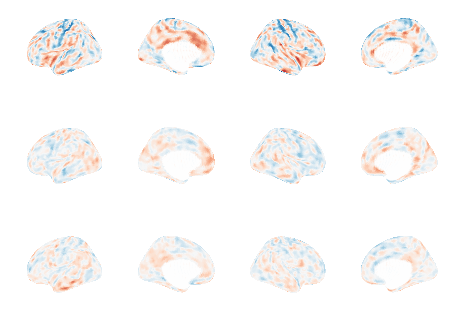

In [43]:
visualize_embeddings(avgs[levels[0]][tasks[0]], level=levels[0], task=tasks[0], vmax=vmax_avg, statistic='avg', save=False,colorbar=colorbar, n_embed=n_components)

## Single subject

In [35]:
latents = {t:{l:None for l in tasks} for t in levels}
subjs = {'e': '025', 'n': '002'}

for level in levels:#level=levels[1]
    for task in tasks:
        path, _ = get_files(path=gccadir, subject=subjs[level], level=level, task=task, flag='_gcca')[0]
        
        h5f = h5py.File(gccadir / path,'r')
        latent = h5f[h5_key][:]
        h5f.close()
        latents[level][task] = latent

In [44]:
vmax = max(max(a.flatten()) for l in latents.values() for a in l.values())

colorbar=True

if not colorbar:
    make_cbar(vmax, 'individuals')

for level in levels:
    for task in tasks:
        print(level, task)
        if not colorbar:
            visualize_embeddings(latents[level][task], level=level, task=task, vmax=vmax_avg, statistic=subjs[level], save=True, colorbar=colorbar)
        else:
            visualize_embeddings(latents[level][task], level=level, task=task, statistic=f'{subjs[level]}_unnormalized', save=True, colorbar=colorbar)

e restingstate
e openmonitoring
e compassion
n restingstate
n openmonitoring
n compassion


## Various visualizations

In [111]:
std_diffs = {}
avg_diffs = {}
for task in tasks:
    std_diffs[task] = stds['e'][task] - stds['n'][task]
    avg_diffs[task] = avgs['e'][task] - avgs['n'][task]

In [113]:
for task in tqdm(tasks):
    visualize_embeddings(avg_diffs[task] / stds['n'][task], level='zscore', task=task, statistic='zscore', vmax=1)

100%|██████████| 3/3 [04:28<00:00, 87.40s/it]


In [9]:
task = tasks[2]
level = levels[0]

paths = get_files(path=gccadir, level=level, task=task, flag='_gcca')
latents = []

n_load = len(paths)

for path,subj in tqdm(paths[:n_load]):
    h5f = h5py.File(gccadir / path,'r')
    latent = h5f[h5_key][:]
    h5f.close()
    latents.append(latent)

100%|██████████| 29/29 [00:00<00:00, 342.84it/s]


In [ ]:
idxs = np.random.choice(18000,size=10)
fig, axes = plt.subplots(3, 2, figsize=(10, 5))
for i,ax in enumerate(axes.flatten()):
    for idx in idxs:
        ax.hist(np.array(latents)[:,idx,i],alpha=0.3)

In [ ]:
#idxs = np.random.choice(18000,size=10)
fig, axes = plt.subplots(3, 2, figsize=(10, 5), sharex=True, sharey=True)
for i,ax in enumerate(axes.flatten()):
    #for idx in idxs:
    ax.hist(np.array(latents)[0,:,i],alpha=0.3)
        
fig.suptitle(f'{level}, {task}')

Text(0.5, 0.98, 'e, compassion')

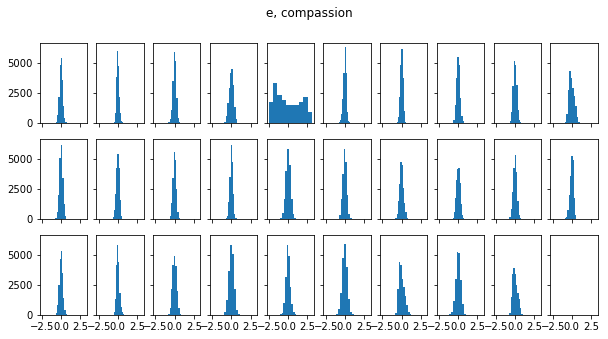

In [11]:
fig, axes = plt.subplots(3, 10, figsize=(10, 5), sharex=True, sharey=True)
for i,ax in enumerate(axes.flatten()):
    if i >= 29:
        continue
    ax.hist(np.array(latents)[i,:,0],alpha=1)
        
fig.suptitle(f'{level}, {task}')

IndexError: index 1 is out of bounds for axis 2 with size 1

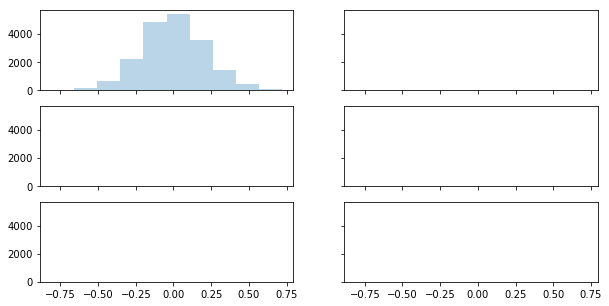

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(10, 5), sharex=True, sharey=True)
for i,ax in enumerate(axes.flatten()):
    #for idx in idxs:
    ax.hist(np.array(latents)[0,:,i],alpha=0.3)
        
fig.suptitle(f'{level}, {task}')

IndexError: index 29 is out of bounds for axis 0 with size 29

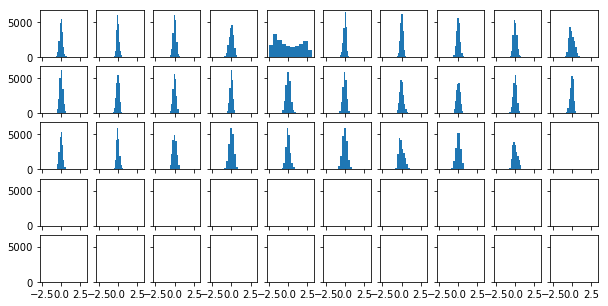

In [13]:
fig, axes = plt.subplots(5, 10, figsize=(10, 5), sharex=True, sharey=True)
for i,ax in enumerate(axes.flatten()):
    if i >= 47:
        continue
    ax.hist(np.array(latents)[i,:,0],alpha=1)
        
fig.suptitle(f'{level}, {task}')

## All Subjects

In [45]:
## Get filenames for each task, novice vs. experienced
## Load a single set of latents

latents = {t:{l:[] for l in tasks} for t in levels}
n_components = 1

for level in levels:
    for task in tasks:
        paths = get_files(path=gccadir, level=level, task=task, flag='_gcca')
        
        temp = []
        n_load = len(paths)

        for path,subj in tqdm(paths[:n_load]):
            h5f = h5py.File(gccadir / path,'r')
            latent = h5f[h5_key][:][:,0]
            h5f.close()
            temp.append(latent)
        
        latents[level][task] = np.array(temp)
            
vmax_all = max([max([max([max(i) for i in lat]) for lat in lev.values()]) for lev in latents.values()])

100%|██████████| 47/47 [00:00<00:00, 478.02it/s]


In [47]:
def visualize_embeddings(embeddings, level, task, statistic, save=True, vmax=None, symmetric_cbar=True,colorbar=False, n_embed = 1):
    res_scale = 1
    fig, axes = plt.subplots(len(embeddings), 4, subplot_kw={'projection': '3d'}, figsize=(res_scale*4, res_scale*len(embeddings)))
    
    plt.subplots_adjust(wspace=0, hspace=0)


    for i in tqdm(range(len(embeddings))):
        ax = axes[i]
        X = embeddings[i,:]

        cortex_left = nib.freesurfer.read_label(externaldir / 'lh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_left] = X[:len(cortex_left)]

        plotting.plot_surf_stat_map(fsa5.infl_left, 
          conn_map, hemi='left', colorbar=False, cmap='RdBu', axes = ax[0],
          vmax=vmax, symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_left,
          conn_map, hemi='left', colorbar=False, cmap='RdBu', view='medial', axes=ax[1], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

        cortex_right = nib.freesurfer.read_label(externaldir / 'rh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_right] = X[len(cortex_left):]

        plotting.plot_surf_stat_map(fsa5.infl_right, 
          conn_map, hemi='right', colorbar=False, cmap='RdBu', axes = ax[2], 
           vmax=vmax,symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_right,
          conn_map, hemi='right', colorbar=colorbar, cmap='RdBu', view='medial', axes=ax[3], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

    #fig.suptitle(f'{statistic}: {level}, {task}', fontsize=20)
    if save:
        plt.savefig(f'../reports/figures/{level}-{task}-{statistic}.png', format='png', bbox_inches='tight')
    else:
        plt.show()
    plt.clf()#plt.close(fig)

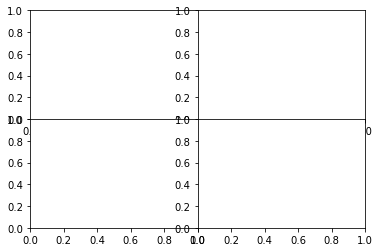

In [58]:
fig, axes = plt.subplots(2,2)
    
plt.subplots_adjust(wspace=-0, hspace=-0)
plt.show()

In [59]:
#task = tasks[0]
#level = levels[1]
mpl.use('Agg')

for level in levels:
    for task in tasks[1:]:
        visualize_embeddings(latents[level][task], level, task, statistic='all_individuals', vmax=vmax_all)

100%|██████████| 47/47 [03:17<00:00,  6.04s/it]


<Figure size 432x288 with 0 Axes>